### Q1. Develop a DMD model to forecast the future population states

#### Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/table.csv')
df = df.set_index(['year'])
df.head()

,hare,lynx
year,,
1845,20,32
1847,20,50
1849,52,12
1851,83,10
1853,64,13


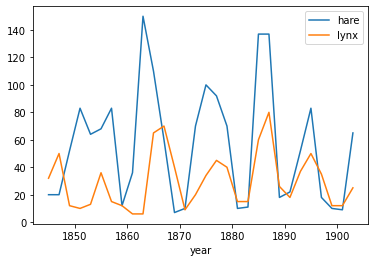

In [3]:
df.plot()

#### Define DMD function 

In [4]:
def DMD(X,Xprime,r):
    
    # Step 1
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) 
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    # Step 2
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T 
    
    # Step 3
    Lambda, W = np.linalg.eig(Atilde) 
    Lambda = np.diag(Lambda)
    
    # Step 4
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W 
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b

#### Prepare variables

In [5]:
years = df.index.values
x1    = df['hare'].values
x2    = df['lynx'].values

#### Interpolate values

In [6]:
def densify(t,y,dt):
    
    f = interp1d(t, y, kind='cubic')
    
    tnew = np.arange(t[0], t[-1], dt)
    ynew = f(tnew)
    return tnew, ynew

In [7]:
dt = 0.1
t, x1 = densify(years,x1, dt)
t, x2 = densify(years,x2, dt)

In [8]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])

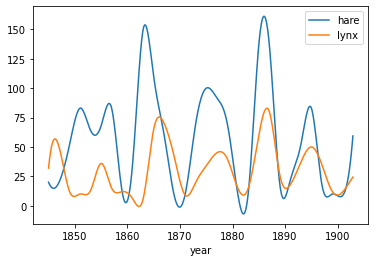

In [9]:
df_new.plot()

#### Step and reshape

In [10]:
axis    = 1 

X1       = np.expand_dims(x1[:-1], axis=axis)
X1prime  = np.expand_dims(x1[1:], axis=axis)

X2       = np.expand_dims(x2[:-1], axis=axis)
X2prime  = np.expand_dims(x2[1:], axis=axis)

X1.shape

(579, 1)

#### Run DMD

In [11]:
Phi_X1, Lambda_X1, b_X1 = DMD(X1, X1prime, 1)
Phi_X2, Lambda_X2, b_X2 = DMD(X2, X2prime, 1)

#### Forecast future population states

In [12]:
def forecast_population(Phi, Lambda, b):
    forecast = []
    omega = np.log(Lambda)/2
    for i,v in enumerate(Phi):
        x = v * np.exp(omega*i) * b
        forecast.append(x)
    return np.array(forecast).squeeze()

In [13]:
df_new = pd.DataFrame({'year':t, 'hare':x1, 'lynx':x2}).set_index(['year'])

In [14]:
df_new['hare_forecast']           = np.nan
df_new['hare_forecast'].iloc[1:]  = forecast_population(Phi_X1, Lambda_X1, b_X1)

df_new['lynx_forecast']           = np.nan
df_new['lynx_forecast'].iloc[1:]  = forecast_population(Phi_X2, Lambda_X2, b_X2)

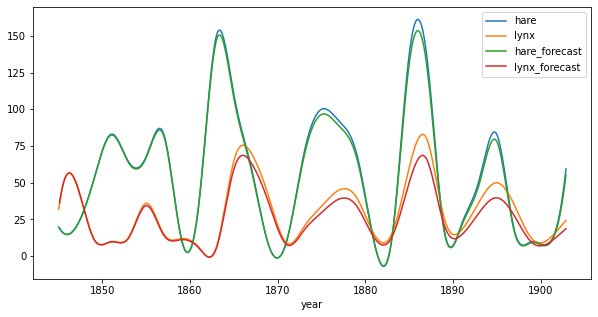

In [15]:
df_new.plot(figsize=(10,5));

# Question

Should Phi_X1 be a matrix with a value for each data point in the input array x1? If so, how to predict into the future, beyond where we have values for Phi?


In [16]:
Phi_X1.shape

(579, 1)

Another way to look at this might be - Should the SVD of X1 return a U of the same shape?

In [17]:
X1.shape

(579, 1)

In [18]:
U,Sigma,VT = np.linalg.svd(X1,full_matrices=0)
U.shape

(579, 1)